In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import geopandas
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

%matplotlib inline
import numpy as np
import os
import pandas as pd
import requests
import shapefile
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
map_crs = ccrs.LambertConformal(central_latitude=35, central_longitude=-100)
cat_plot_colors = {"TSTM": 'palegreen',
                   "MRGL": 'green',
                   "SLGT": 'yellow',
                   "ENH" : 'goldenrod',
                   "MDT" : 'red',
                   "HIGH": 'magenta'}

In [3]:
idate = pd.to_datetime("20210701T01")
idate = datetime.datetime.now()

In [4]:
# Got from iowa e m https://mesonet.agron.iastate.edu/request/gis/spc_outlooks.phtml

if idate < pd.to_datetime("20221128"):
    if pd.to_datetime("20220101") <= idate < pd.to_datetime("20221128"):
        gdf = geopandas.read_file("outlooks_202201010000_202211280000")
    elif pd.to_datetime("20180101") <= idate < pd.to_datetime("20210101"):
        gdf = geopandas.read_file("outlooks_201801010000_202101010000")
    else:
        logging.error(f"can't find {idate}")
    column = "THRESHOLD"
    subset = gdf["DAY"].eq(1) & gdf["CATEGORY"].eq("CATEGORICAL") # & gdf["ISSUE"].eq(idate.strftime("%Y%m%d%H%M"))
    gdf = gdf[subset]
    gdf = gdf[gdf.ISSUE == idate.strftime("%Y%m%d%H%M")]
else:
    ifile = requests.get("https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson")
    gdf = geopandas.GeoDataFrame.from_features(ifile.json())
    gdf = gdf.set_crs("epsg:4269")
    column = "LABEL"
gdf.head(2)

,geometry,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill
0,"MULTIPOLYGON (((-83.01169 41.82062, -83.02000 ...",2,202301191630,202301201200,202301191622,TSTM,General Thunderstorms Risk,#55BB55,#C1E9C1
1,"POLYGON ((-81.94000 41.90000, -80.42000 41.950...",3,202301191630,202301201200,202301191622,MRGL,Marginal Risk,#005500,#66A366


In [5]:
gdf.explore(legend=True, column=column, categories=["TSTM","MRGL","SLGT","ENH","MDT","HIGH"],
           cmap=colors.ListedColormap(list(cat_plot_colors.values())))

In [6]:
start = pd.to_datetime("20190122T01")
end = pd.to_datetime("20191206T01")
for idate in pd.date_range(start=start, end=end, freq="1D"):
    idate = idate.strftime("%Y%m%d%H%M")
    if gdf[column].eq("HIGH").any():
        logging.info(gdf)
        cat = "TSTM"
        for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
            logging.info(f"subtracting {subtract}")
            gdf.loc[gdf[column].eq(cat)] = gdf.loc[gdf[column].eq(cat)].overlay(gdf[gdf[column].eq(subtract)],
                                                                                      how="difference").values
            cat = subtract   
        break
            
print(idate)
gdf.explore(legend=True, column=column, categories=["TSTM","MRGL","SLGT","ENH","MDT","HIGH"],
           cmap=colors.ListedColormap(list(cat_plot_colors.values())))


201912060100


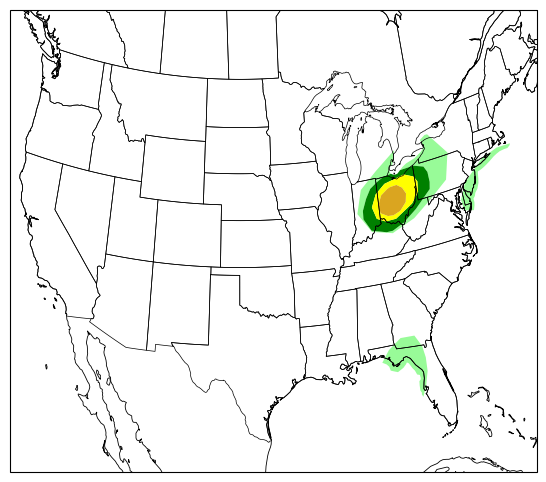

In [7]:
fig = plt.figure(1, figsize=(8,6))
ax = plt.subplot(projection=map_crs)
ax.set_extent([-120, -74, 22, 51])
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)

if gdf.empty:
    logging.warning(f"no {idate}")
else:
    for key in cat_plot_colors.keys():
        geometries = gdf[gdf[column].eq(key)]
        if len(geometries)>0:
            geometries.plot(ax=ax, color=cat_plot_colors[key], transform=ccrs.PlateCarree(), legend=True)

In [8]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 9),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.05)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='k', linewidth=0.25, facecolor='k', alpha=0.05)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [9]:
from awips.dataaccess import DataAccessLayer
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("grid")
request.setLocationNames("LAMP2p5")
request.setParameters("PROLGHT2hr")
#request.setLevels("2.0FHAG")

# Take a look at our request
print(request)

grid_locations = DataAccessLayer.getAvailableLevels(request)
grid_locations.sort()
list(grid_locations)

cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

# Get the most recent grid data
response = DataAccessLayer.getGridData(request, [fcstRun[0]])

print('Number of available times:', len(times))
print('Number of available forecast runs:', len(fcstRun))

grid = response[0]
data = grid.getRawData()
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

data[data == -999999] = np.nan
data.min()
np.nanmin(data)

DefaultDataRequest(datatype=grid, identifiers={}, parameters=['PROLGHT2hr'], levels=[], locationNames=['LAMP2p5'], envelope=None)
Number of available times: 28
Number of available forecast runs: 14


0.0

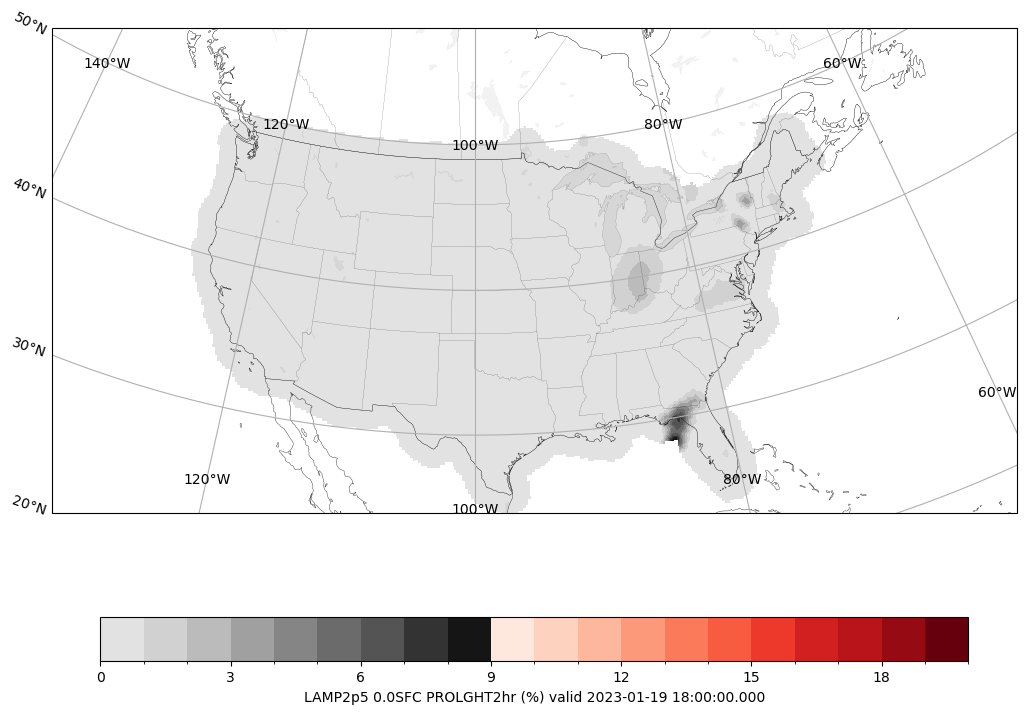

In [11]:
import nclcmaps
cmap = plt.get_cmap('rainbow')
from matplotlib.colors import ListedColormap, BoundaryNorm
test = nclcmaps.colors['MPL_Greys'][25::] + [[1,1,1]] + nclcmaps.colors['MPL_Reds'][10::]
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0,21,1), ncolors=cmap.N, clip=True)

fig, ax = make_map(bbox=bbox, projection = map_crs)
cs = ax.pcolormesh(lons, lats, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

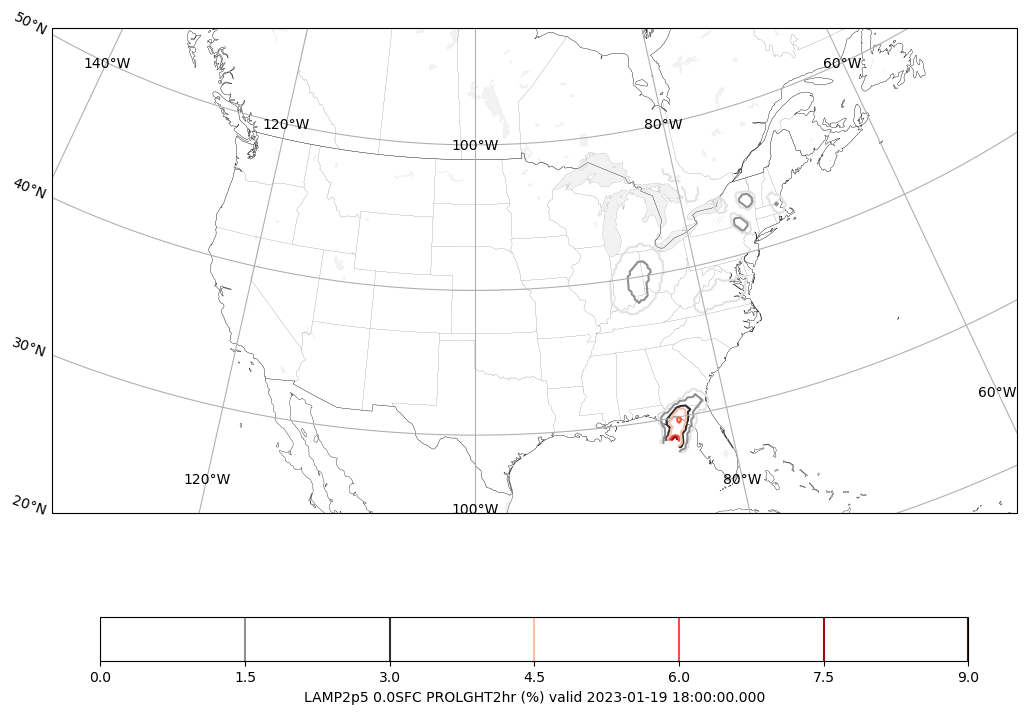

In [12]:
fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
cs2 = ax2.contour(lons, lats, data, 80, cmap=cmap, levels=6,
                  transform=ccrs.PlateCarree(),
                  vmin=np.nanmin(data), vmax=np.nanmax(data))
cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation='horizontal')
cbar2.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

In [13]:
from ml_functions import configs_match, get_argparser, get_features, savedmodel_default, brier_skill_score, grab_predictors
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import yaml

2023-01-19 11:53:37.064549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 11:53:38.326288: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 11:53:50.748368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/

In [14]:
idate = pd.to_datetime(idate).round("D")
idate = pd.to_datetime("20210601")
idate

Timestamp('2021-06-01 00:00:00')

In [19]:
parser = get_argparser()
args = parser.parse_args(args="--model HRRR --batchsize 1024 --neurons 1024 --optim adam"
                         " --trainstart 19700101 --trainend 20201202 --teststart 20201202T12"
                         " --testend 20220101 --epochs 30 --learning 0.001 --kfold 5".split())
df = grab_predictors(args, idate, idir='/glade/work/sobash/NSC_objects')

In [20]:
args

Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=10, folds=None, glm=False, kfold=5, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='adam', reg_penalty=0.01, rptdist=40, savedmodel=None, seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('1970-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), suite='default', twin=2)

In [21]:
features = get_features(args)
df = df[features]
features = df
features

CAPESHEAR  CAPESHEAR-N3T1  CAPESHEAR-N3T3  \
valid_time          y  x                                                  
2021-06-01 01:00:00 48 12  16891.710938    22814.662109    22086.294922   
                    49 12  20026.957031    18378.808594    18384.023438   
                    69 12  13433.490234    14963.968750    15553.566406   
                    70 12  19582.652344    18817.775391    18989.416016   
                    47 13  28454.628906    26916.332031    26534.074219   
...                                 ...             ...             ...   
2021-06-03 00:00:00 25 46     10.852808      105.849403      113.793953   
                    26 46    301.867584      160.741989      192.251068   
                    27 46     95.733521      339.167603      347.841217   
                    28 46    515.395081      395.812927      386.404816   
                    29 46     25.747799      385.953003      340.361603   

                           CAPESHEAR-N3T5  CAPESHEAR-N5T1  CAPESHEAR-N5T3  \
valid_time          y  x                                                    
2021-06-01 01:00:00 48 12    21552.320312    23232.898438    22889.439453   
                    49 12    18337.699219    20694.445312    20367.023438   
                    69 12    15616.395508    14537.997070    14578.780273   
                    70 12    18704.580078    15102.717773    14968.280273   
                    47 13    26128.203125    28031.238281    27516.007812   
...                                   ...             ...             ...   
2021-06-03 00:00:00 25 46      124.740059      272.997101      292.682068   
                    26 46      222.914780      339.816589      350.493408   
                    27 46      348.151215      377.532471      385.354797   
                    28 46      360.757965      546.292969      542.651062   
                    29 46      279.814240      712.726624      673.274658   

                           CAPESHEAR-N5T5       CREF  CREF-N3T1  CREF-N3T3  \
valid_time          y  x                                                     
2021-06-01 01:00:00 48 12    22717.240234 -10.000000  -3.685099   5.802212   
                    49 12    20205.306641 -10.000000  -9.956190  -3.959362   
                    69 12    14498.946289  -4.339506  16.147463  17.564043   
                    70 12    14942.573242 -10.000000   0.986111   5.556413   
                    47 13    27215.234375 -10.000000  -9.983368  -7.480881   
...                                   ...        ...        ...        ...   
2021-06-03 00:00:00 25 46      309.245605 -10.000000 -10.000000 -10.000000   
                    26 46      355.343597 -10.000000 -10.000000 -10.000000   
                    27 46      386.833527 -10.000000 -10.000000 -10.000000   
                    28 46      526.107971 -10.000000 -10.000000 -10.000000   
                    29 46      609.138489 -10.000000 -10.000000  -9.963477   

                           ...  W_UP_MAX-N3T3  W_UP_MAX-N3T5  W_UP_MAX-N5T1  \
valid_time          y  x   ...                                                
2021-06-01 01:00:00 48 12  ...       1.076844       1.251627       3.889344   
                    49 12  ...       0.500000       0.564127       1.076844   
                    69 12  ...      29.201843      29.814127      29.451843   
                    70 12  ...      27.812500      27.812500      29.201843   
                    47 13  ...       0.701844       1.126627      12.201844   
...                        ...            ...            ...            ...   
2021-06-03 00:00:00 25 46  ...       1.753495       1.753495       2.878495   
                    26 46  ...       2.937905       2.937905       3.690995   
                    27 46  ...       3.690995       3.690995       3.690995   
                    28 46  ...       3.690995       3.690995       3.690995   
                    29 46  ...       3.690995       3.690995       3.690995   

         

In [22]:
y_preds = pd.DataFrame()
for ifold in range(args.kfold):
    for thisfit in range(args.nfits):
        savedmodel_thisfitfold = f"nn/HRRR.default.10flash.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.Adam.L20.01.lr0.001.dr0.0_{thisfit}/{args.kfold}fold{ifold}"
        yl = yaml.load(open(
            os.path.join(savedmodel_thisfitfold, "config.yaml"), "r"),
            Loader=yaml.Loader)
        labels = yl["labels"]
        # delete labels so we can make DataFrame from rest of dictionary.
        del (yl["labels"])
        del (yl["args"])
        # scaling values DataFrame as from .describe()
        sv = pd.DataFrame(yl).set_index("columns").T
        if sv.columns.size != features.columns.size:
            logging.error(
                f"size of yaml and features columns differ {sv.columns} {features.columns}"
            )
        if not all(sv.columns == features.columns):
            logging.info(f"reordering columns")
            features = features.reindex(columns=sv.columns)
        assert all(
            sv.columns == features.columns
        ), f"columns {features.columns} don't match when model was trained {sv.columns}"

        logging.info(f"loading {savedmodel_thisfitfold}")
        model = load_model(
            savedmodel_thisfitfold,
            custom_objects=dict(brier_skill_score=brier_skill_score))
        norm_features = (features - sv.loc["mean"]) / sv.loc["std"]
        # Grab numpy array of predictions.
        Y = model.predict(norm_features.to_numpy(dtype='float32'))
        Y = pd.DataFrame(Y, columns=labels, index=features.index)
        # prepend "fit" level to multilevel DataFrame
        Y = pd.concat([Y], keys=[thisfit], names=["fit"])
        # prepend "fold" level
        Y = pd.concat([Y], keys=[ifold], names=["fold"])
        # concatenate this fit/fold to the y_preds DataFrame
        y_preds = pd.concat([y_preds, Y], axis="index")

2023-01-19 11:57:29.090597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-19 11:57:29.092464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc59): /proc/driver/nvidia/version does not exist
2023-01-19 11:57:29.188383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1962/1962 [==============================] - 2s 812us/step


In [23]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = y_preds.groupby(level=[
    "valid_time", "y", "x"
]).mean()
assert "fit" not in ensmean.index.names, "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

In [24]:
ensmean

sighail_40km_2hr  sigwind_40km_2hr  \
valid_time          y  x                                        
2021-06-01 01:00:00 21 33      1.519476e-07      9.719126e-07   
                       34      1.689801e-07      1.080015e-06   
                       35      1.623602e-07      1.060280e-06   
                       36      1.374931e-07      9.195188e-07   
                    22 29      7.786143e-08      4.895104e-07   
...                                     ...               ...   
2021-06-03 00:00:00 79 41      1.070231e-06      3.447225e-06   
                       42      7.102490e-06      1.321310e-05   
                       43      6.031283e-05      5.370520e-05   
                       44      7.832010e-05      6.700490e-05   
                    80 41      7.232780e-07      2.671625e-06   

                           hailone_40km_2hr  wind_40km_2hr  torn_40km_2hr  \
valid_time          y  x                                                    
2021-06-01 01:00:00 21 33          0.000005       0.000044       0.000003   
                       34          0.000006       0.000048       0.000003   
                       35          0.000006       0.000047       0.000003   
                       36          0.000005       0.000042       0.000002   
                    22 29          0.000003       0.000023       0.000001   
...                                     ...            ...            ...   
2021-06-03 00:00:00 79 41          0.000025       0.000171       0.000011   
                       42          0.000111       0.000651       0.000040   
                       43          0.000605       0.002600       0.000158   
                       44          0.000773       0.003135       0.000185   
                    80 41          0.000018       0.000134       0.000009   

                           any_40km_2hr  flashes_40km_2hr  
valid_time          y  x                                   
2021-06-01 01:00:00 21 33      0.000055          0.000498  
                       34      0.000060          0.000582  
                       35      0.000059          0.000596  
                       36      0.000052          0.000495  
                    22 29      0.000029          0.000241  
...                                 ...               ...  
2021-06-03 00:00:00 79 41      0.000214          0.002597  
                       42      0.000804          0.013366  
                       43      0.003239          0.079730  
                       44      0.003916          0.101577  
                    80 41      0.000166          0.001776  

[62784 rows x 7 columns]

<GeoAxesSubplot: title={'center': '20210601T01 to 20210603T00'}, xlabel='lon', ylabel='lat'>

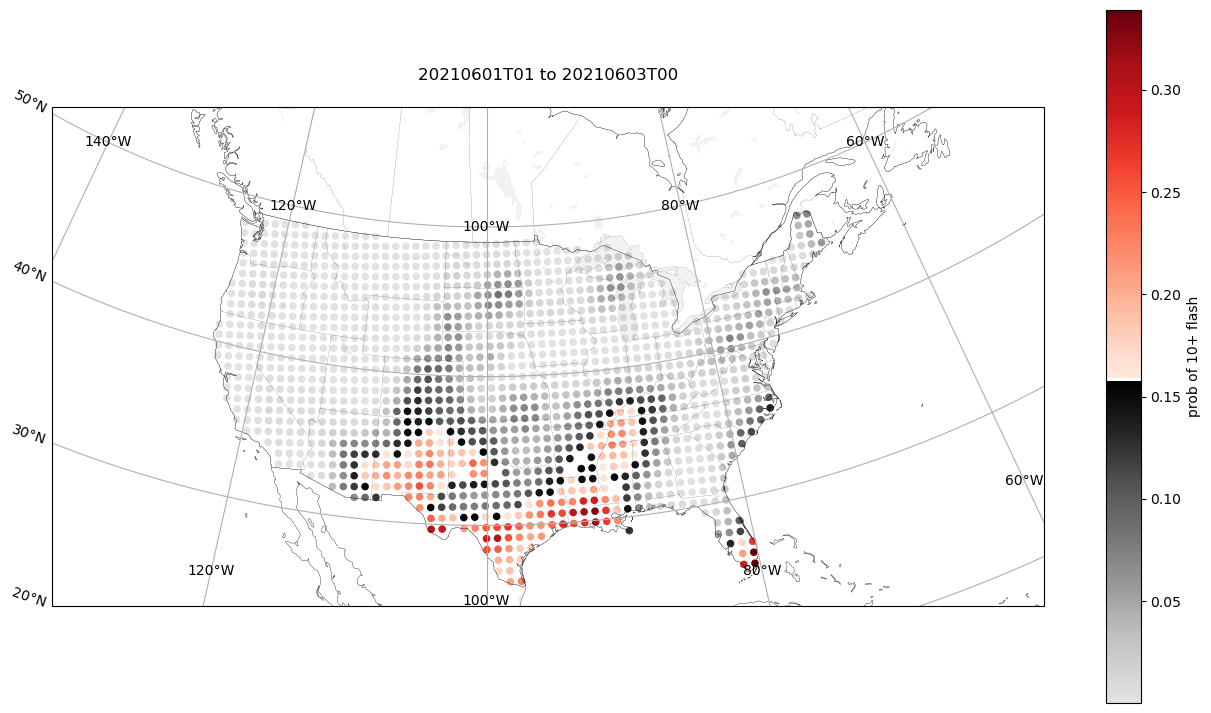

In [28]:
fig, ax = make_map(bbox=bbox, projection=map_crs)
f = "any_40km_2hr"
if "flashes_40km_2hr" in ensmean:
    f = "prob of 10+ flash"
    features[f] = ensmean["flashes_40km_2hr"]
valid_times = ensmean.index.get_level_values("valid_time")
title=f'{valid_times.min().strftime("%Y%m%dT%H")} to {valid_times.max().strftime("%Y%m%dT%H")}'
features.groupby(["y","x"]).mean()[["lat","lon",f]].plot(ax=ax, title=title, cmap=cmap, 
                                                               kind="scatter",x="lon",y="lat",c=f,
                                                              transform=ccrs.PlateCarree())

In [ ]:
pd.concat([features[["lat","lon"]], Y.groupby(["y","x"]).mean()])

In [26]:
pd.__version__

'1.5.2'

In [ ]:
np.array(test).shape

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("GreysReds", test)

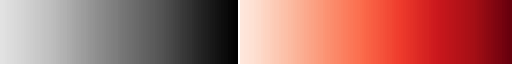

In [27]:
cmap

In [5]:
from importlib import reload

In [6]:
reload(pd)

<module 'pandas' from '/Users/ahijevyc/miniconda3/envs/new/lib/python3.10/site-packages/pandas/__init__.py'>